動機和分析目的：每個人都可以使用五倍券，因此希望了解大家對五倍券的看法


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
%pwd

'/content'

In [31]:
cd /content/drive/MyDrive

/content/drive/MyDrive


# **對PTT Gossip版的五倍券議題進行情緒分析**

# **1.安裝套件**

In [32]:
%pip install wordcloud

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 

In [34]:
# cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

--2021-12-02 06:12:54--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.203.101, 74.125.203.102, 74.125.203.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f5b352jtuoj3v041d6s6hdt2oi7fpft6/1638425550000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-02 06:12:55--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f5b352jtuoj3v041d6s6hdt2oi7fpft6/1638425550000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|74.125

# **2.資料前處理**

##**2.1基本資料介紹**


*   資料來源：文字平台收集PTT Gossip版2021-09-14 ~ 2021-11-14 所有文章
*   資料集：/content/drive/MyDrive/hw/期中報告資料 2/new五倍券_articleMetaData.csv
*   關鍵字：五倍券、數位、紙本、綁定、振興、紓困
*   資料時間：2021-09-14 ~ 2021-11-14





In [35]:
#匯入資料
MetaData = pd.read_csv('/content/drive/MyDrive/referendum/公投_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('/content/drive/MyDrive/referendum/公投_articleReviews.csv', encoding='UTF-8')

In [36]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 4584 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一\n\n日本交通全亞洲最佳，事故死亡率全亞洲最低\n\n但日本是有一系列配...
1,[新聞]陳菊接掌監察院長、人權委員會主委：一,2020/08/01,06:05:33,https://www.ptt.cc/bbs/Gossiping/M.1596261935....,s66449,Gossiping,39,8,21,陳菊接掌監察院長、人權委員會主委：一生最後階段責任\n\n 記者陳家祥／台北報導\n\n\n...
2,Re:[新聞]【國會風暴】超震撼！4立委1黨主席收賄,2020/08/01,10:32:47,https://www.ptt.cc/bbs/Gossiping/M.1596277969....,xampp,Gossiping,5,2,3,講到陳水扁\n\n才想到\n\n這次時力黨主席被收押禁見\n\n有沒有可能也是政治迫害?\n...


In [37]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(3)

共有 322922 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,shiaoyao,噓,2020-08-01 16:15:00,:不是阿，我是根據你說你在日本生活百年的外人來說的阿
1,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,shiaoyao,→,2020-08-01 16:16:00,:而且根據日本目前在世的最高歲數的，不是你的歲數阿
2,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,shiaoyao,→,2020-08-01 16:16:00,:可見你是沒有日本政府認證的居民


In [38]:
# 再篩一次文章
keywords = ['重啟核四','反萊豬','反萊豬進口','公投綁大選','公投併大選','護藻礁','珍愛藻礁']
toMatch = '|'.join(keywords)

In [39]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(1034, 10)


In [40]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [43]:
print(Reviews.shape)
Reviews.head(10)

(115668, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:支持
1,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:找點去睡
2,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:上次那個排隊慘況要重現了，CC
3,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:公投被民進黨搞得跟笑話一樣花那麼多錢搞個大型民調
4,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:KMT輸到脫褲就要還權於民???我呸....
5,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:KMT講打破一黨獨大、還權於民這是發在就可的文嘛?
6,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:丁丁：
7,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:誰理你，黨主席當成這樣，還不下台
8,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:當初反最大聲的不就是你們這狗渣黨嗎?迴光返照???
9,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,:哈哈哈哈哈哈哈哈哈哈


##**2.2資料清理**


*   去除NA值
*   去除不是中文的字詞



In [44]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [45]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [47]:
MetaData.head(10)
#MetaData['sentence']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,老下一步江啟臣領銜提案恢復公投綁大選打破一黨獨大還權於民蘋果日報黃韋銓台北報導國民黨主席江啟...
1,[新聞]國民黨推公投綁大選公投案將全台座談,2020/08/18,05:02:28,https://www.ptt.cc/bbs/Gossiping/M.1597726952....,Rrrxddd,Gossiping,45,8,17,媒體來源記者署名劉冠廷完整新聞標題國民黨推公投綁大選公投案將全台座談連署完整新聞內文中央社記...
2,[新聞]憂民進黨一黨獨大國民黨拋公投提案：恢,2020/08/18,10:18:18,https://www.ptt.cc/bbs/Gossiping/M.1597745900....,osalucard,Gossiping,79,27,18,媒體來源新頭殼記者署名黃建豪完整新聞標題憂民進黨一黨獨大國民黨拋公投提案完整新聞內文國民黨今...
3,Re:[問卦]如果政府有蓋牌那台灣怎沒爆發蛤,2020/08/19,03:27:40,https://www.ptt.cc/bbs/Gossiping/M.1597807662....,Nagasumi,Gossiping,14,4,4,中國資訊的確是不透明隱瞞疫情也是真的不過他們高度的封鎖與隔離手段也是真的這本來就是極權政府的...
4,[新聞]藍營青年軍組返聯特攻隊籲美與ROC建交,2020/08/19,14:24:30,https://www.ptt.cc/bbs/Gossiping/M.1597847074....,babalajj,Gossiping,19,5,2,備註請放最後面違者新聞文章刪除媒體來源自由時報記者署名彭琬馨完整新聞標題藍營青年軍組返聯特攻...
5,[新聞]「彰化採檢風波有打到民進黨」江啟臣,2020/08/21,15:02:11,https://www.ptt.cc/bbs/Gossiping/M.1598022133....,nerudaliu,Gossiping,66,15,31,備註請放最後面違者新聞文章刪除媒體來源自由記者署名陳昀完整新聞標題彰化採檢風波有打到民進黨江...
6,[新聞]羅智強邊騎車邊酸蔡:國家越不安小英票越多,2020/08/27,07:24:50,https://www.ptt.cc/bbs/Gossiping/M.1598513093....,wyin,Gossiping,134,15,87,媒體來源新頭殼記者署名黃建豪完整新聞標題羅智強邊騎車邊酸蔡國家越不安小英票越多完整新聞內文羅...
7,Re:[新聞]羅智強邊騎車邊酸蔡:國家越不安小英票越多,2020/08/27,07:45:46,https://www.ptt.cc/bbs/Gossiping/M.1598514348....,joicow,Gossiping,9,2,0,聽你們國民黨靠背我就飽了公投綁大選你們這個垃圾黨公投的投票選項最多就是你們出的造成大家投票投...
8,[新聞]推公投綁大選羅智強:第二階段連署將全島徒步苦行,2020/08/27,14:40:02,https://www.ptt.cc/bbs/Gossiping/M.1598539204....,MagicMoney,Gossiping,27,5,15,備註請放最後面違者新聞文章刪除媒體來源新頭殼記者署名蔡坤龍嘉義市報導完整新聞標題推公投綁大選...
9,Re:[新聞]推公投綁大選羅智強:第二階段連署將全島徒步苦行,2020/08/27,14:47:15,https://www.ptt.cc/bbs/Gossiping/M.1598539638....,win8719,Gossiping,4,1,0,我想問一下徒步全島苦行需要花費幾天時間我看新聞是有天的所以他議員工作有天不做了嗎如果我沒記錯...


In [48]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
Reviews.head(10)
#Reviews['cmtContent']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,支持
1,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,找點去睡
2,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,上次那個排隊慘況要重現了
3,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,公投被民進黨搞得跟笑話一樣花那麼多錢搞個大型民調
4,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,輸到脫褲就要還權於民我呸
5,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,講打破一黨獨大還權於民這是發在就可的文嘛
6,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,丁丁
7,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,誰理你黨主席當成這樣還不下台
8,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,當初反最大聲的不就是你們這狗渣黨嗎迴光返照
9,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,哈哈哈哈哈哈哈哈哈哈


##**2.3文章斷詞**
中文文集我們使用 jieba 套件進行斷詞與移除停用字

In [49]:
#設定繁體中文詞庫
jieba.set_dictionary('/content/drive/MyDrive/referendum/dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('/content/drive/MyDrive/referendum/dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('/content/drive/MyDrive/referendum/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /content/drive/MyDrive/referendum/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u0d879557490209863d75c26d74052496.cache
Loading model cost 2.406 seconds.
Prefix dict has been built successfully.


In [50]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [51]:
MetaData['word'] = MetaData.sentence.apply(getToken)

In [53]:
MetaData_token = MetaData.explode('word') # 將word欄位展開

In [54]:
MetaData_token.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,老下一步江啟臣領銜提案恢復公投綁大選打破一黨獨大還權於民蘋果日報黃韋銓台北報導國民黨主席江啟...,一步
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,老下一步江啟臣領銜提案恢復公投綁大選打破一黨獨大還權於民蘋果日報黃韋銓台北報導國民黨主席江啟...,江啟
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,老下一步江啟臣領銜提案恢復公投綁大選打破一黨獨大還權於民蘋果日報黃韋銓台北報導國民黨主席江啟...,領銜
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,老下一步江啟臣領銜提案恢復公投綁大選打破一黨獨大還權於民蘋果日報黃韋銓台北報導國民黨主席江啟...,提案
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,老下一步江啟臣領銜提案恢復公投綁大選打破一黨獨大還權於民蘋果日報黃韋銓台北報導國民黨主席江啟...,恢復


In [55]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [56]:
Reviews_token = Reviews.explode('word') # 將word欄位展開

In [57]:
Reviews_token.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,word
0,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,支持,支持
1,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,找點去睡,找點
2,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,上次那個排隊慘況要重現了,上次
2,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,上次那個排隊慘況要重現了,排隊
2,[新聞]【老Ｋ下一步】江啟臣領銜提案恢復「公,2020/08/18,04:10:31,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,taiwan08,Gossiping,52,12,16,上次那個排隊慘況要重現了,慘況


In [58]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

,artDate,artUrl,word
0,2020/08/18,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,一步
0,2020/08/18,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,江啟
0,2020/08/18,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,領銜
0,2020/08/18,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,提案
0,2020/08/18,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,恢復


In [59]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [60]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

,artDate,word,size
224101,2021-11-20,同意,755
157844,2021-10-26,同意,655
157480,2021-10-26,公投,555
118995,2021-05-11,同意,546
174723,2021-10-30,同意,486
152732,2021-10-25,公投,431
224222,2021-11-20,四個,430
153071,2021-10-25,同意,394
174644,2021-10-30,台灣,341
174135,2021-10-30,公投,326


# 3.lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

##**3.1準備LIWC字典**
*  全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版
*  分為正向情緒與負向情緒



In [78]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"/content/drive/MyDrive/referendum/dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])

In [79]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative
...,...,...
1706,魅力,positive
1707,鮮明,positive
1708,鮮美,positive
1709,鼓勵,positive


##**3.2情緒字典與斷詞結果進行合併**
將情緒字典與斷詞結果進行合併。可以先觀察每天的ptt文章數量，大約在9/21有較高的討論聲量，其他天討論聲量則是差不多。

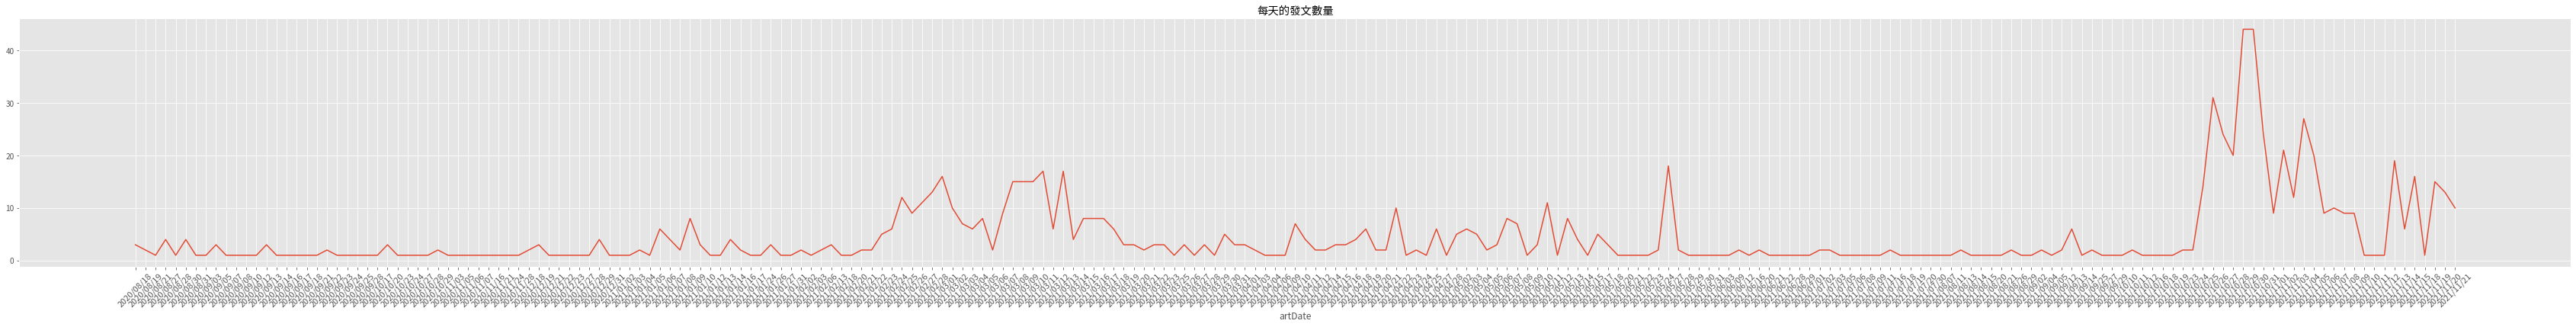

In [69]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])
matplotlib.rc('font', family='Taipei Sans TC Beta')
plt.figure(figsize=(60,6))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

##**3.3 正負向情緒分數聲量折線圖**
分別畫出文集中，正向（positive）與負向（negative）情緒的折線

In [80]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

,artDate,sentiments,size
0,2020-08-18,negative,38
1,2020-08-18,positive,25
2,2020-08-19,negative,17
3,2020-08-19,positive,17
4,2020-08-21,negative,23


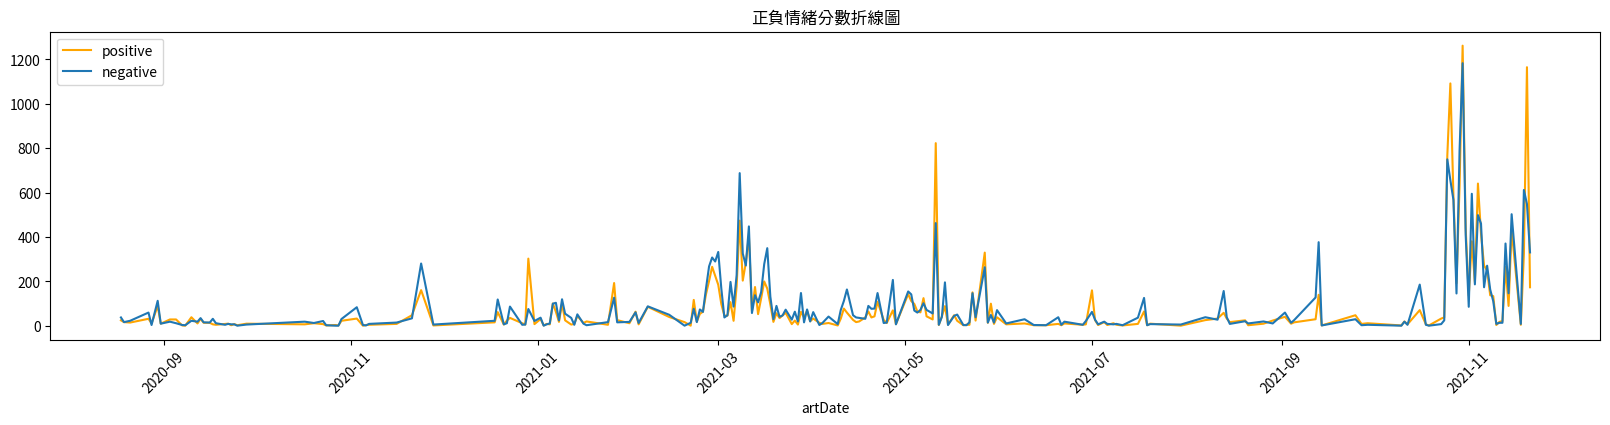

In [83]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(20,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artDate')
plt.show()

從上圖可以看出情緒主要以負面為主

##**3.4 正負向情緒分數比例折線圖**

In [85]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

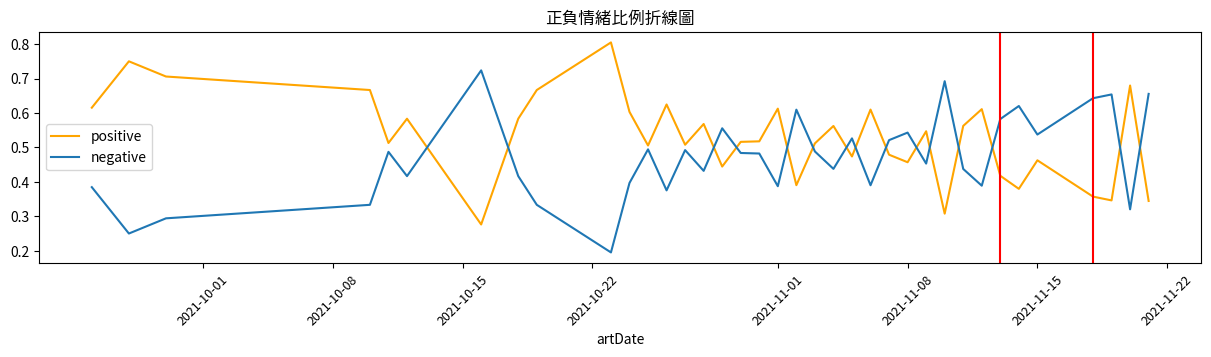

In [86]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/09/15']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(15,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
plt.axvline(x=datetime.strptime('2021-11-13', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-11-18', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-11-24', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-11-05', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

##**3.5文字雲**
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [88]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict

2021-10-28 文字雲

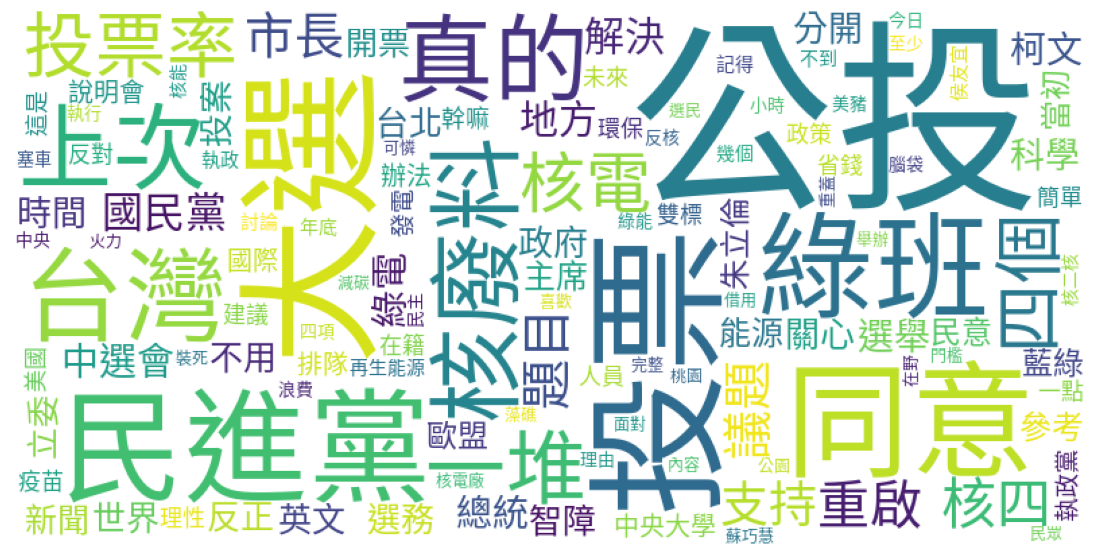

In [106]:
dict_1028 = Wc_dict(word_count,"2021-10-28",200,5)

font = '/content/drive/MyDrive/referendum/SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1028)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

2021-11-13 文字雲

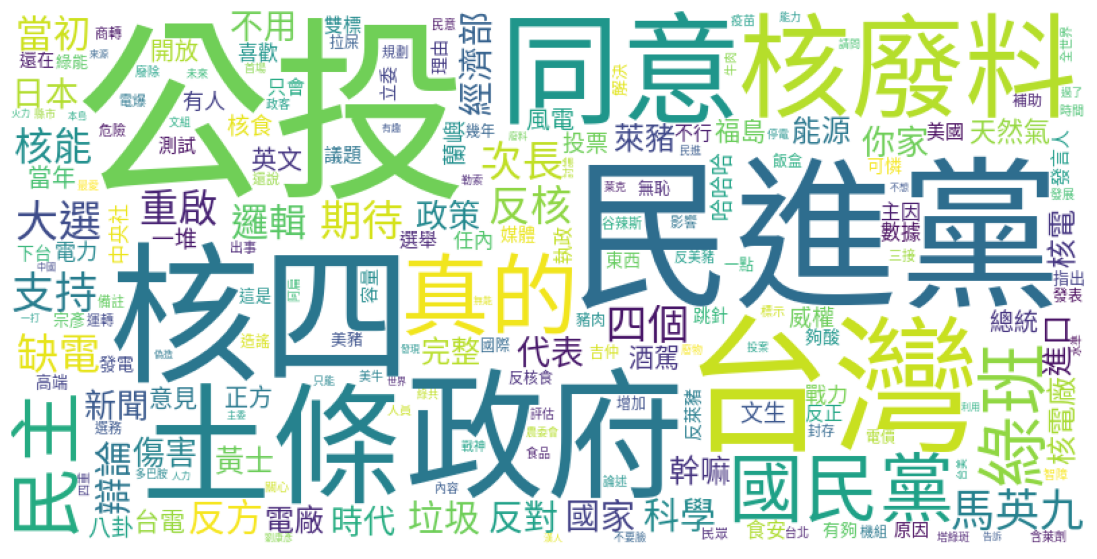

In [91]:
dict_1113 = Wc_dict(word_count,"2021-11-13",200,5)

font = '/content/drive/MyDrive/referendum/SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1113)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

2021-10-29 文字雲

In [ ]:
#dict_1029 = Wc_dict(word_count,"2021-10-29",200,5)

#font = '/content/drive/MyDrive/Colab Notebooks/SourceHanSansTW-Regular.otf' #中文字型路徑
#wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
#wordcloud.generate_from_frequencies(dict_1029)
#plt.figure(figsize = (14,7))
#plt.imshow(wordcloud)
#plt.axis("off") #把作圖的座標軸關掉 
#plt.show()

2021-11-05 文字雲

In [ ]:
#dict_1105 = Wc_dict(word_count,"2021-11-05",200,5)

#font = '/content/drive/MyDrive/Colab Notebooks/SourceHanSansTW-Regular.otf' #中文字型路徑
#wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
#wordcloud.generate_from_frequencies(dict_1105)
#plt.figure(figsize = (14,7))
#plt.imshow(wordcloud)
#plt.axis("off") #把作圖的座標軸關掉 
#plt.show()

##**3.6 情緒代表字**
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [93]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
61,同意,positive,5579
150,支持,positive,2847
75,垃圾,negative,2262
50,反對,negative,1446
160,智障,negative,996


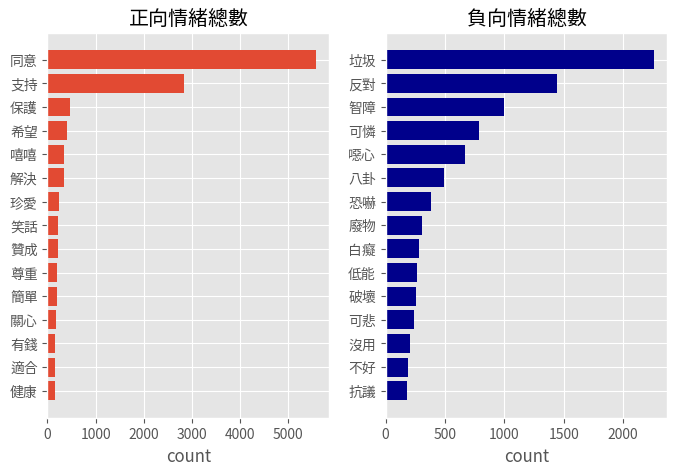

In [94]:
matplotlib.rc('font', family='Taipei Sans TC Beta')
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Bet'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

從分析中可以看出大家可能對五倍券並不是特別滿意，負面詞彙數量遠大於正面數量


2021-10-28 正負情緒代表字

In [107]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_1028 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-28"].sort_values(by=['size'], ascending=False)
sentiment_1028.head()

,artDate,word,sentiments,size
1491,2021-10-28,同意,positive,54
1497,2021-10-28,支持,positive,19
1502,2021-10-28,解決,positive,17
1504,2021-10-28,關心,positive,13
1498,2021-10-28,智障,negative,12


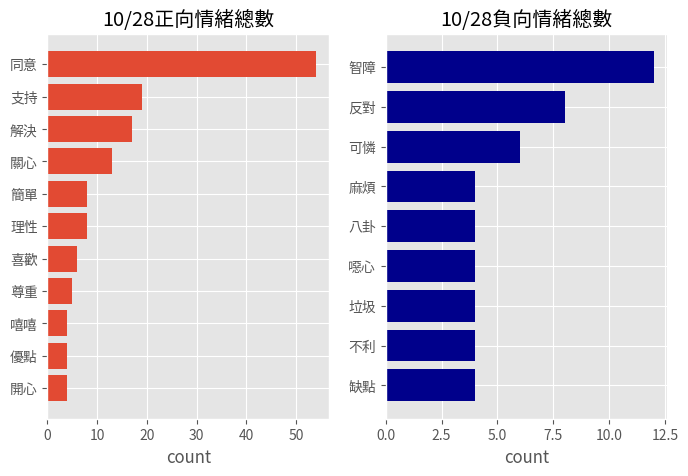

In [108]:
p_sum = sentiment_1028[sentiment_1028["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1028[sentiment_1028["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示

plt.subplot(121)
plt.title('10/28正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('10/28負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

9/22開始數位綁定，民眾負面情緒大於正面情緒，網民可能對於五倍券以及執政黨有所不滿，但也可以看出不少正面情緒在討論優惠議題，民眾認為綁定流程簡單易懂

2021-11-13 正負情緒代表字

In [102]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_1113 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-11-13"].sort_values(by=['size'], ascending=False)
sentiment_1113.head()

,artDate,word,sentiments,size
2033,2021-11-13,同意,positive,63
2043,2021-11-13,支持,positive,39
2036,2021-11-13,垃圾,negative,25
2028,2021-11-13,反對,negative,24
2025,2021-11-13,傷害,negative,21


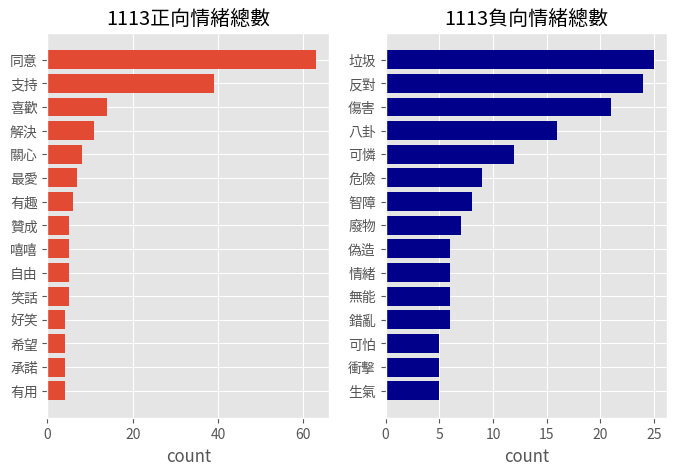

In [103]:
p_sum = sentiment_1113[sentiment_1113["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1113[sentiment_1113["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示

plt.subplot(121)
plt.title('1113正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('1113負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

10/08五倍券開始使用後民眾對於五倍券的負面情緒開始緩和，負面情緒詞開始降低，但負面詞還是較高

##**3.7 歸類正負面文章**
* 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。 
* 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。



In [109]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments,artUrl,negative,positive
0,https://www.ptt.cc/bbs/Gossiping/M.1597723838....,14,8
1,https://www.ptt.cc/bbs/Gossiping/M.1597726952....,10,6
2,https://www.ptt.cc/bbs/Gossiping/M.1597745900....,14,11
3,https://www.ptt.cc/bbs/Gossiping/M.1597807662....,13,4
4,https://www.ptt.cc/bbs/Gossiping/M.1597847074....,4,13


In [110]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,620
1,positive,402


**正負情緒文章數量統計圖**

In [111]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
#article_type_date

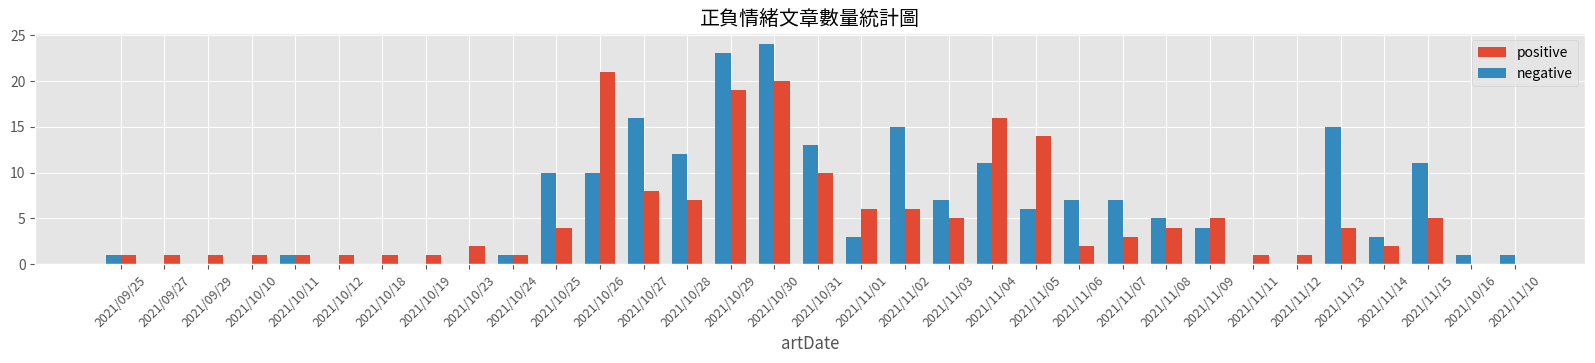

In [112]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/09/15")&(article_type_date["artDate"]<="2021/11/15")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/09/15")&(article_type_date["artDate"]<="2021/11/15")]

plt.figure(figsize=(20,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

##**3.8情緒關鍵字**
把正面和負面的文章挑出來，並和斷詞結果合併

In [113]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

**情緒關鍵字:負面情緒文章**

In [114]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

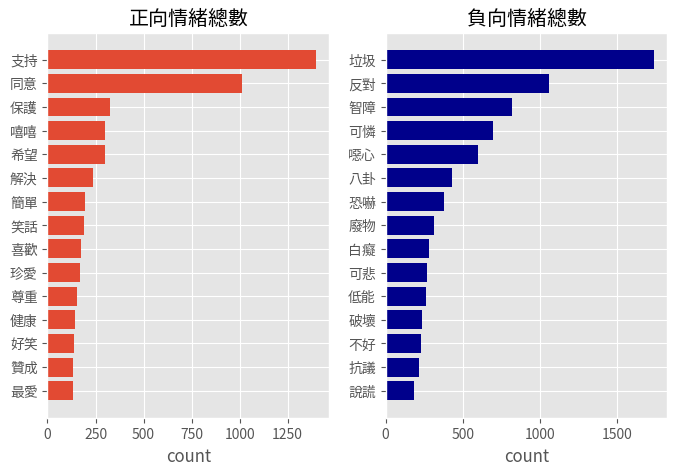

In [115]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

**情緒關鍵字:正面情緒文章**

In [116]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

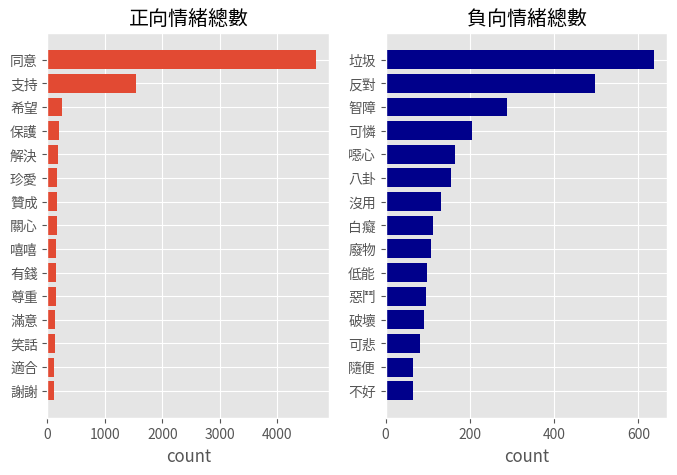

In [117]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

正面文章跟負面文章中的正負面情緒文字並無太大的差別

# **分析PTT Gossip版的五倍券相關文章之詞彙關係**

#**1.安裝套件**

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [119]:
# cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2021-12-02 07:30:30--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.23.100, 74.125.23.113, 74.125.23.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.23.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fn13k86oidibck3m59p2ditmskce5h07/1638430200000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-02 07:30:31--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fn13k86oidibck3m59p2ditmskce5h07/1638430200000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.23.132, 2404:6800:4008:c02::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|74.125.23.1

#**2.資料前處理**

##**2.1基本資料介紹**
*   資料來源：文字平台收集PTT Gossip版2021-09-14 ~ 2021-11-14 所有文章
*   資料集：/content/drive/MyDrive/hw/期中報告資料 2/new五倍券_articleMetaData.csv
*   關鍵字：五倍券、數位、紙本、綁定、振興、紓困
*   資料時間：2021-09-14 ~ 2021-11-14

In [120]:
MetaData = pd.read_csv('/content/drive/MyDrive/referendum/公投_articleMetaData.csv', encoding='UTF-8')

##**2.2資料清理**
*   去除NA值
*   去除特殊字元與標點符號


In [121]:
MetaData.sentence.isna().values.any() #資料中有na值

True

In [122]:
MetaData[MetaData.sentence.isna()] #有na值得資料

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
1252,Re:[新聞]藻礁公投若過學者：藻礁與中南部民眾的,2021/03/05,05:47:33,https://www.ptt.cc/bbs/Gossiping/M.1614923256....,hamasakiayu,Gossiping,8,7,0,NaN
1518,Re:[新聞]立委考察藻礁大潭里長批公投趕走三接,2021/03/16,15:06:16,https://www.ptt.cc/bbs/Gossiping/M.1615907178....,coober,Gossiping,11,1,4,NaN
1757,Re:[新聞]苗博雅問核四商轉公投？柯文哲：愚人,2021/04/10,02:14:11,https://www.ptt.cc/bbs/Gossiping/M.1618020853....,jerrylin,Gossiping,117,30,3,NaN
1771,Re:[新聞]苗博雅問核四商轉公投？柯文哲：愚人,2021/04/11,01:20:16,https://www.ptt.cc/bbs/Gossiping/M.1618104018....,agonist5566,Gossiping,26,2,13,NaN
2039,Re:[新聞]快訊／中選會公告：藻礁、反萊豬公投皆「,2021/05/07,03:38:47,https://www.ptt.cc/bbs/Gossiping/M.1620358731....,DCSHK,Gossiping,36,17,3,NaN
4400,Re:[問卦]核四公投應該不會過了,2021/11/19,02:54:46,https://www.ptt.cc/bbs/Gossiping/M.1637290488....,hamasakiayu,Gossiping,17,7,0,NaN


In [123]:
MetaData = MetaData[~MetaData.sentence.isna()] # 去除na值
MetaData

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一\n\n日本交通全亞洲最佳，事故死亡率全亞洲最低\n\n但日本是有一系列配...
1,[新聞]陳菊接掌監察院長、人權委員會主委：一,2020/08/01,06:05:33,https://www.ptt.cc/bbs/Gossiping/M.1596261935....,s66449,Gossiping,39,8,21,陳菊接掌監察院長、人權委員會主委：一生最後階段責任\n\n 記者陳家祥／台北報導\n\n\n...
2,Re:[新聞]【國會風暴】超震撼！4立委1黨主席收賄,2020/08/01,10:32:47,https://www.ptt.cc/bbs/Gossiping/M.1596277969....,xampp,Gossiping,5,2,3,講到陳水扁\n\n才想到\n\n這次時力黨主席被收押禁見\n\n有沒有可能也是政治迫害?\n...
3,Re:[新聞]馬英九：李登輝時期通過一中涵義決議為,2020/08/02,02:51:52,https://www.ptt.cc/bbs/Gossiping/M.1596336714....,nqj,Gossiping,24,2,2,http://i.imgur.com/Na3dIzm.jpg\n李登輝弄的一中憲法兩岸條例\...
4,Re:[問卦]朱宥勳要如何看待焦糖暴走事件呢？,2020/08/02,10:02:30,https://www.ptt.cc/bbs/Gossiping/M.1596362552....,Pocketsun,Gossiping,6,4,0,不清楚朱宥勳會如何看待焦糖近日暴走，但可以回顧一下這兩人過去的「並肩作戰」。\n兩年前朱宥勳...
...,...,...,...,...,...,...,...,...,...,...
4579,[新聞]未勸戴口罩遭檢舉挨罵店員：客不戴口罩,2021/11/21,12:51:13,https://www.ptt.cc/bbs/Gossiping/M.1637499075....,deatiai,Gossiping,22,10,3,未勸戴口罩遭檢舉挨罵 店員：客不戴口罩算我們責任？\n\n2021-11-21\n\n聯合報...
4580,[新聞]核四重啟要多久林飛帆：至少要7至10年,2021/11/21,13:05:55,https://www.ptt.cc/bbs/Gossiping/M.1637499957....,GOD5566GOD,Gossiping,237,34,137,1.媒體來源:\n\n聯合新聞網\n\n2.記者署名:\n\n黃寅\n\n3.完整新聞標題:...
4581,[新聞]「把他趕出去！」羅智強大酸：蘇貞昌蔡英,2021/11/21,13:59:07,https://www.ptt.cc/bbs/Gossiping/M.1637503150....,shawnm80,Gossiping,636,349,52,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n聯合報\n\n2.記者署名:\n記...
4582,Re:[新聞]「把他趕出去！」羅智強大酸：蘇貞昌蔡英,2021/11/21,14:10:13,https://www.ptt.cc/bbs/Gossiping/M.1637503816....,iammatrix,Gossiping,216,122,12,蘇貞昌是台灣有史以來最蠻橫跋扈的行政院長。\n如果他是第二，沒人敢說第一。\n\n他這幾年的...


In [124]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
#只留下中文字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))

In [126]:
MetaData.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一日本交通全亞洲最佳事故死亡率全亞洲最低但日本是有一系列配套努力好幾十年才行...
1,[新聞]陳菊接掌監察院長、人權委員會主委：一,2020/08/01,06:05:33,https://www.ptt.cc/bbs/Gossiping/M.1596261935....,s66449,Gossiping,39,8,21,陳菊接掌監察院長人權委員會主委一生最後階段責任記者陳家祥台北報導前總統府祕書長陳菊日在副總統...
2,Re:[新聞]【國會風暴】超震撼！4立委1黨主席收賄,2020/08/01,10:32:47,https://www.ptt.cc/bbs/Gossiping/M.1596277969....,xampp,Gossiping,5,2,3,講到陳水扁才想到這次時力黨主席被收押禁見有沒有可能也是政治迫害畢竟時力之前跟執政黨對槓很多次...
3,Re:[新聞]馬英九：李登輝時期通過一中涵義決議為,2020/08/02,02:51:52,https://www.ptt.cc/bbs/Gossiping/M.1596336714....,nqj,Gossiping,24,2,2,李登輝弄的一中憲法兩岸條例蔡英文承諾不變善意不變公投法關鐵牢阻止台灣人公投建國法理台獨實質承...
4,Re:[問卦]朱宥勳要如何看待焦糖暴走事件呢？,2020/08/02,10:02:30,https://www.ptt.cc/bbs/Gossiping/M.1596362552....,Pocketsun,Gossiping,6,4,0,不清楚朱宥勳會如何看待焦糖近日暴走但可以回顧一下這兩人過去的並肩作戰兩年前朱宥勳與焦糖在以民...


##**2.3文章斷詞**

In [128]:
#設定繁體中文詞庫
jieba.set_dictionary('/content/drive/MyDrive/referendum/dict/dict.txt.big')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('/content/drive/MyDrive/referendum/dict/stopwords.txt') as f:
    stopWords = [line.strip() for line in f.readlines()]

In [129]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [130]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

Building prefix dict from /content/drive/MyDrive/referendum/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u0d879557490209863d75c26d74052496.cache
Loading model cost 1.499 seconds.
Prefix dict has been built successfully.


In [131]:
# 將word欄位展開
data = data.explode('word')

In [132]:
data.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一日本交通全亞洲最佳事故死亡率全亞洲最低但日本是有一系列配套努力好幾十年才行...,日本
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一日本交通全亞洲最佳事故死亡率全亞洲最低但日本是有一系列配套努力好幾十年才行...,統一
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一日本交通全亞洲最佳事故死亡率全亞洲最低但日本是有一系列配套努力好幾十年才行...,日本
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一日本交通全亞洲最佳事故死亡率全亞洲最低但日本是有一系列配套努力好幾十年才行...,交通
0,Re:[新聞]又是突開車門肇禍！父女被撞到噴飛險,2020/08/01,03:20:52,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,ilovesumika,Gossiping,85,0,16,所以應該跟日本統一日本交通全亞洲最佳事故死亡率全亞洲最低但日本是有一系列配套努力好幾十年才行...,亞洲


In [133]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [134]:
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一人分,1
1,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一半,1
2,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一台,6
3,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一坪,1
4,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一堆,3
...,...,...,...
352903,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,難以,2
352904,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,高端,1
352905,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,黑髮人,1
352906,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,黯然,1


# **3. TF-IDF**
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度

##**3.1 計算每篇文章的詞數**

In [135]:
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,1579
1,https://www.ptt.cc/bbs/Gossiping/M.1596261935....,310
2,https://www.ptt.cc/bbs/Gossiping/M.1596277969....,45
3,https://www.ptt.cc/bbs/Gossiping/M.1596336714....,93
4,https://www.ptt.cc/bbs/Gossiping/M.1596362552....,278
...,...,...
4573,https://www.ptt.cc/bbs/Gossiping/M.1637499075....,107
4574,https://www.ptt.cc/bbs/Gossiping/M.1637499957....,200
4575,https://www.ptt.cc/bbs/Gossiping/M.1637503150....,142
4576,https://www.ptt.cc/bbs/Gossiping/M.1637503816....,71


##**3.2 合併需要的資料欄位**
*   合併 每個詞彙在每個文章中出現的次數 與 每篇文章的詞數
*   新增各個詞彙在所有詞彙中的總數欄位



In [151]:
referendum_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
referendum_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一人分,1,1579
1,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一半,1,1579
2,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一台,6,1579
3,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一坪,1,1579
4,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一堆,3,1579
...,...,...,...,...
352903,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,難以,2,176
352904,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,高端,1,176
352905,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,黑髮人,1,176
352906,https://www.ptt.cc/bbs/Gossiping/M.1637504474....,黯然,1,176


##**3.3 計算 tf-idf 值**
*   以每篇文章爲單位，計算每個詞彙的 tf-idf 值
  *   TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。
      詞彙在該文件中出現次數 / 該文件中詞彙總數
  *   IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取 log。評估詞彙在文集的獨特性
log( 總文件數量 / 包含該詞彙的文件數量 )







In [152]:
#計算tf
referendum_words_tf_idf = referendum_words.assign(tf = referendum_words.iloc[:,2]/referendum_words.iloc[:,3])

In [153]:
# 計算每個詞彙出現在幾篇文章中
idf_df = referendum_words.groupby(['word'],as_index=False).size()
referendum_words_tf_idf = referendum_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [154]:
#計算idf
referendum_words_tf_idf = referendum_words_tf_idf.assign(idf = referendum_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

referendum_words_tf_idf = referendum_words_tf_idf.drop(labels=['size'],axis=1)

In [155]:
#計算tf*idf
referendum_words_tf_idf = referendum_words_tf_idf.assign(tf_idf = referendum_words_tf_idf.iloc[:,4]*referendum_words_tf_idf.iloc[:,5])

In [156]:
referendum_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一人分,1,1579,0.000633,3.660676,0.002318
1,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一半,1,1579,0.000633,1.768581,0.001120
2,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一台,6,1579,0.003800,2.405403,0.009140
3,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一坪,1,1579,0.000633,3.058616,0.001937
4,https://www.ptt.cc/bbs/Gossiping/M.1596252054....,一堆,3,1579,0.001900,1.052150,0.001999


##**3.4檢視結果**

In [157]:
# 選出每篇文章，tf-idf值最大的五個詞
group = referendum_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [158]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                                 
https://www.ptt.cc/bbs/Gossiping/M.1596252054.A... 372     日本  0.088774
                                                   514     統一  0.044070
                                                   43    中華民國  0.040376
                                                   45      主權  0.032027
                                                   576    託管地  0.023184
https://www.ptt.cc/bbs/Gossiping/M.1596261935.A... 707  人權委員會  0.094469
                                                   821    監察院  0.053700
                                                   856     見證  0.046492
                                                   706     人權  0.044678
                                                   732     同仁  0.037717
https://www.ptt.cc/bbs/Gossiping/M.1596277969.A... 905     時力  0.238018
                                                   915     迫害  0.163770
                                                   907     永明  0.141491
                                                   885     上銬  0.081348
                                                   898     將徐  0.081348

**計算整個文集中較常 tf-idf 值高的字**

In [159]:
# 從每篇文章挑選出tf-idf最大的十個詞
(referendum_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
18271,藻礁,130
6012,國民黨,113
5067,同意,111
17137,罷免,109
20446,連署,108
12574,核四,102
15400,疫苗,101
980,中國,100
17175,美國,96
12507,柯文,94


#**4. 透過結巴斷詞與N-gram幫助建立字典**

##**4.1 Bigram**

In [160]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [161]:
referendum_bigram = MetaData.copy()
referendum_bigram["word"] = referendum_bigram.sentence.apply(bigram_getToken)



RuntimeError: ignored

In [ ]:
coupon_bigram = coupon_bigram.explode('word')
coupon_bigram.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]要徵收多少個五倍券可以買一隻IPone13,2021/09/14,18:39:33,https://www.ptt.cc/bbs/Gossiping/M.1631644776....,LouisLEE,Gossiping,3,0,2,各位胎嘎賀打給賀我大木啦借一下剛看到的圖想必庫克叔叔是聽到台灣月有元可拿就準備來收割了的配置...,胎嘎賀 給賀
0,[問卦]要徵收多少個五倍券可以買一隻IPone13,2021/09/14,18:39:33,https://www.ptt.cc/bbs/Gossiping/M.1631644776....,LouisLEE,Gossiping,3,0,2,各位胎嘎賀打給賀我大木啦借一下剛看到的圖想必庫克叔叔是聽到台灣月有元可拿就準備來收割了的配置...,給賀 大木
0,[問卦]要徵收多少個五倍券可以買一隻IPone13,2021/09/14,18:39:33,https://www.ptt.cc/bbs/Gossiping/M.1631644776....,LouisLEE,Gossiping,3,0,2,各位胎嘎賀打給賀我大木啦借一下剛看到的圖想必庫克叔叔是聽到台灣月有元可拿就準備來收割了的配置...,大木 想必


**統計最常出現的bigram組合**

In [ ]:
# 計算每個組合出現的次數
coupon_bigram_count = coupon_bigram.groupby(["word"],as_index=False).size()

In [ ]:
# 清除包含英文或數字的bigram組合
wb_filter = list(coupon_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
coupon_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
26921,數位 綁定,274
24137,振興 五倍,163
26803,數位 五倍,111
39302,紙本 五倍,71
39951,綁定 數位,64
3530,五倍 券官網,59
39795,綁定 五倍,50
3853,五倍 數位,50
51796,電子 支付,47
26877,數位 支付,46


##**4.2 Trigram**

In [ ]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
water_trigram = MetaData.copy()
water_trigram["word"] = water_trigram.sentence.apply(trigram_getToken)
water_trigram = water_trigram.explode('word')
water_trigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]要徵收多少個五倍券可以買一隻IPone13,2021/09/14,18:39:33,https://www.ptt.cc/bbs/Gossiping/M.1631644776....,LouisLEE,Gossiping,3,0,2,各位胎嘎賀打給賀我大木啦借一下剛看到的圖想必庫克叔叔是聽到台灣月有元可拿就準備來收割了的配置...,胎嘎賀 給賀 大木
0,[問卦]要徵收多少個五倍券可以買一隻IPone13,2021/09/14,18:39:33,https://www.ptt.cc/bbs/Gossiping/M.1631644776....,LouisLEE,Gossiping,3,0,2,各位胎嘎賀打給賀我大木啦借一下剛看到的圖想必庫克叔叔是聽到台灣月有元可拿就準備來收割了的配置...,給賀 大木 想必
0,[問卦]要徵收多少個五倍券可以買一隻IPone13,2021/09/14,18:39:33,https://www.ptt.cc/bbs/Gossiping/M.1631644776....,LouisLEE,Gossiping,3,0,2,各位胎嘎賀打給賀我大木啦借一下剛看到的圖想必庫克叔叔是聽到台灣月有元可拿就準備來收割了的配置...,大木 想必 庫克


**統計最常出現的trigram組合**

In [ ]:
# 計算每個組合出現的次數
water_trigram_count = water_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
wb_filter = list(water_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
water_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
4652,五倍 數位 綁定,40
57452,開放 數位 綁定,30
45421,綁定 數位 五倍,20
57794,關貿 網路 公司,19
13754,台北 市長 柯文,16
14183,台灣 民意 基金會,13
17358,基本工資 審議 委員會,13
49699,行政院 振興 五倍,12
32955,最新 民意 顯示,12
30615,數位 綁定 五倍,11


從上面的 bigram 和 trigram 的結果中，我們發現"數位 綁定","振興 五倍","五倍券 官網","電子 支付","數位 支付"可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。

#**5. 使用自建字典**

In [ ]:
#新增五倍券相關自定義字典
jieba.load_userdict('/content/drive/MyDrive/期中專案報告/final五倍券/dict/五倍券user_dict.txt')

**使用自建辭典進行斷詞與計算**

In [ ]:
#剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [ ]:
#再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
wb_filter = list(word_count2["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
word_count2 = word_count2[wb_filter].sort_values(by=['count'], ascending=False)
word_count2.head(10)

,artUrl,word,count
44689,https://www.ptt.cc/bbs/Gossiping/M.1634691435....,食券,31
29912,https://www.ptt.cc/bbs/Gossiping/M.1633680226....,食券,30
44494,https://www.ptt.cc/bbs/Gossiping/M.1634691435....,店家,26
6013,https://www.ptt.cc/bbs/Gossiping/M.1632268031....,抽籤,25
44437,https://www.ptt.cc/bbs/Gossiping/M.1634691435....,台灣,24
10880,https://www.ptt.cc/bbs/Gossiping/M.1632296508....,台北,23
44890,https://www.ptt.cc/bbs/Gossiping/M.1634702282....,唐鳳,21
29132,https://www.ptt.cc/bbs/Gossiping/M.1633664640....,基本工資,20
44579,https://www.ptt.cc/bbs/Gossiping/M.1634691435....,登記,20
38087,https://www.ptt.cc/bbs/Gossiping/M.1633947303....,外帶,20


#**6. 建立Ngram預測模型**

In [ ]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [ ]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [ ]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [ ]:
text = '數位'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 紙本, probability: 0.0909
next word: 綁定, probability: 0.0455
next word: 優惠, probability: 0.0394
next word: 加碼, probability: 0.0364
next word: 振興, probability: 0.0333


In [ ]:
text = '支付'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 方式, probability: 0.114
next word: 綁定, probability: 0.0682
next word: 工具, probability: 0.053
next word: 信用卡, probability: 0.053
next word: 台灣, probability: 0.0379


#**7. Bigram視覺化**

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
water_bigram2 = MetaData.copy()
water_bigram2["word"] = water_bigram2.sentence.apply(bigram_getToken_dict)

In [ ]:
water_bigram2 = water_bigram2.explode('word')
# water_bigram2.head(3)

In [ ]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('振興', '五倍券'), 153),
 (('紙本', '五倍券'), 71),
 (('有沒有', '八卦'), 43),
 (('五倍券', '數位綁定'), 39),
 (('綁定', '數位'), 37)]

In [ ]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.3 for w in  G.edges(data=True)]

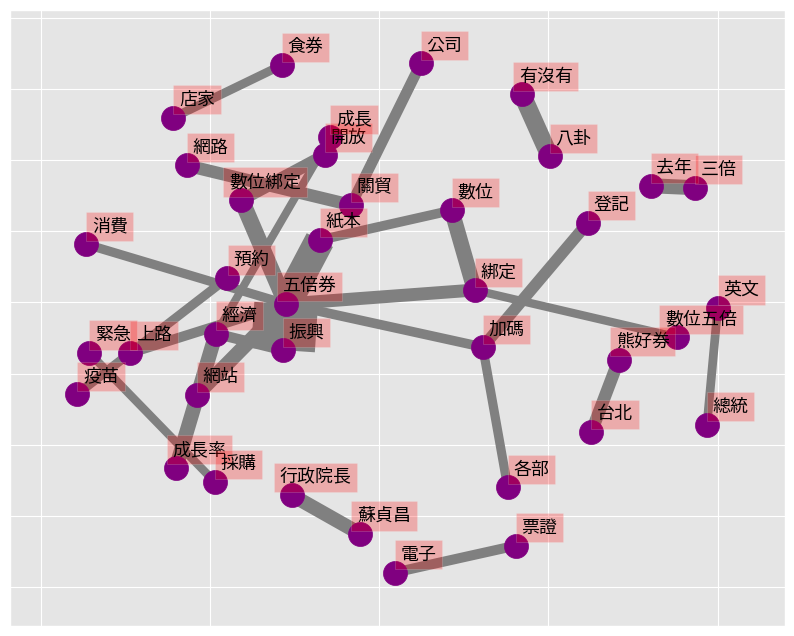

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

透過上面所建立的bigram和count,我們選擇最常出現的前30大詞彙組合來製作出該關係圖，可以發現「數位 五倍券」、「數位 綁定」、「數位 支付」這幾個組合線特別粗，代表這幾個組合是最常被提及的字詞組合

#**8. Pairwise correlation**
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)

In [ ]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [ ]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [ ]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [ ]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]



In [ ]:
bigram_df

,word,word2,n,cor
0,振興,五倍券,153,0.167169
1,紙本,五倍券,71,0.011406
2,有沒有,八卦,43,0.417858
3,五倍券,數位綁定,39,0.096014
4,綁定,數位,37,0.319133
...,...,...,...,...
495,優惠,民眾,5,0.178659
496,加碼,措施,5,0.180342
497,流量,管制,5,0.228671
498,數位,綁訂,5,0.154572




```
# 此內容會顯示為程式碼
```

##**8.1 和 紙本, 數位 相關性最高的 15 個詞彙**

In [ ]:
c_sum = bigram_df[(bigram_df["word"]=="紙本")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="數位")].sort_values(by=['cor'], ascending = False).head(15)

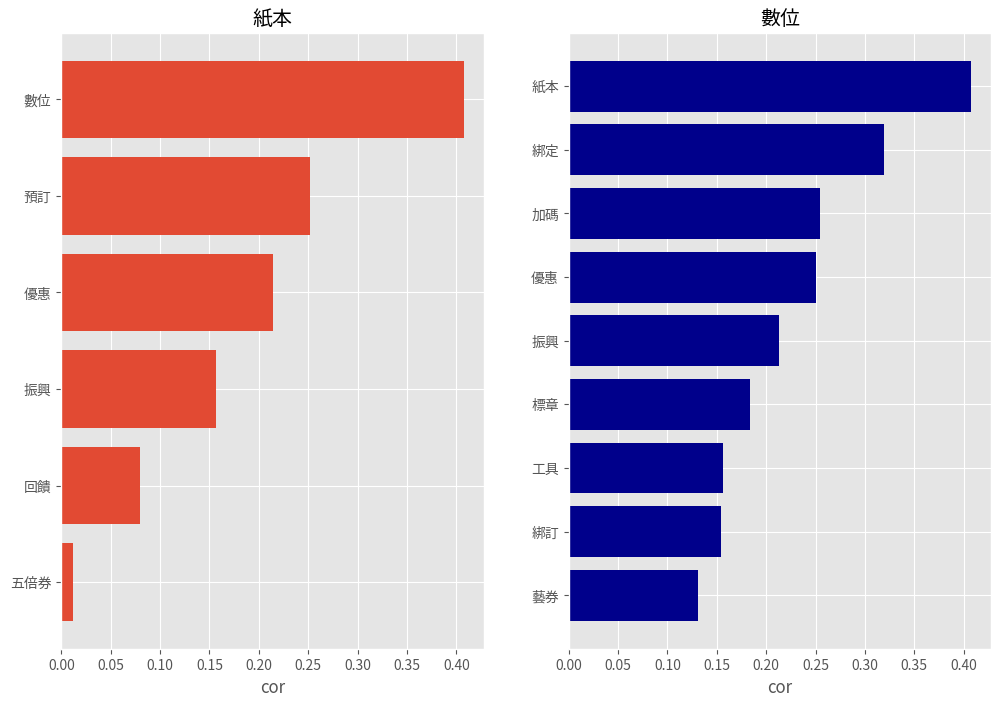

In [ ]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('紙本')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('數位')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")


plt.show()

由上面兩張圖我們可以看出：和「紙本」相關性最高的前五名詞彙為「數位」、「預訂」、「優惠」、「回饋」、「五倍券」;和「數位」相關性最高的前五名詞彙為「綁定」、「紙本」、「支付」、「加碼」、「振興五倍券」等,可以看出不管是數位還是紙本都在關心優惠。

##**8.2 使用詞彙關係圖畫出相關性大於0.4的組合**

In [ ]:
bigram_df[bigram_df["cor"]>0.4]

,word,word2,n,cor
2,有沒有,八卦,43,0.417858
6,去年,三倍,36,0.475603
9,行政院長,蘇貞昌,34,0.765063
11,數位,紙本,30,0.407621
16,關貿,公司,26,0.475666
...,...,...,...,...
468,超前,部署,5,0.844454
469,蓮霧,釋迦,5,0.912493
472,編列,億元,5,0.455121
478,健保,快易通,5,0.523763


In [ ]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [ ]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

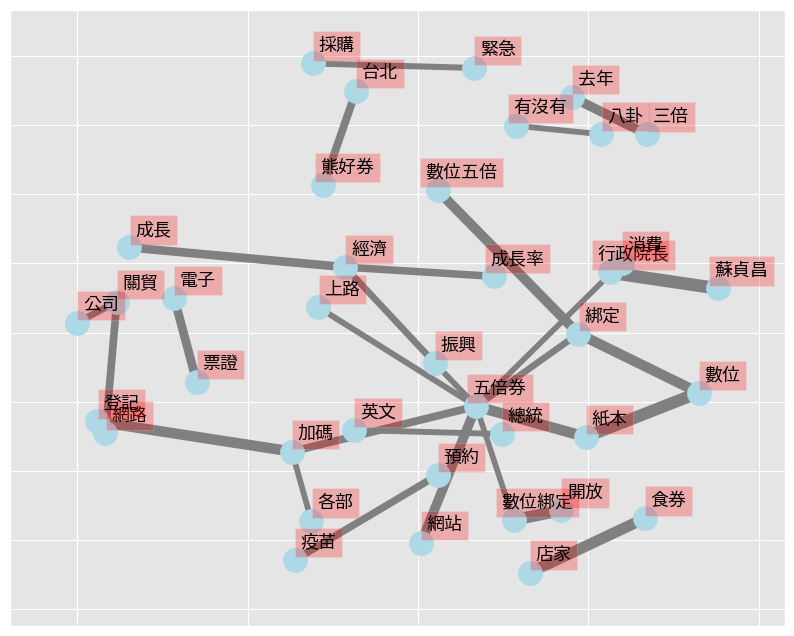

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

可以看出此圖與上面bigram視覺化的結果相似，相關性大於0.4的組合有「店家 好食券」、「經濟 振興」、「台北 熊好券」。除了討論五倍券以外其他加碼券的討論聲量也很高。

#**9. 計算文章相似度**
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章

In [ ]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)

In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,一一,一下子,一下子把,一个,一之軒,一事,一二三,一五,一人,一人領,一件,一任,一份,一位,一來一往,一個個,一個多月,一個月,一個樣,一倍,一傳十,一億,一元,一先,一兩,一兩千,一兩句,一兩天,一兩萬,一共,一再,一再強調,一出,一出場,一切辦法,一切都是,一到,一刷,一副,一劑,...,點開,點閱,點餐,點點,黨內,黨則,黨團,黨外,黨工,黨庫,黨政,黨政軍,黨派,黨產會,黨立委,黨籍,黨繼,黨證,黨養,黴體,鼎王,鼓勵,鼓鼓掌,鼻子,鼻祖,鼻酸,鼻頭,齊心,齊心合力,齊聲,齊酸網,齊頭式,齒輪油,龍山寺,龍說,龍雞,龍頭,龐大,龔明鑫,龜笑
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()  
print(transformer) 
#將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()


,一一,一下子,一下子把,一个,一之軒,一事,一二三,一五,一人,一人領,一件,一任,一份,一位,一來一往,一個個,一個多月,一個月,一個樣,一倍,一傳十,一億,一元,一先,一兩,一兩千,一兩句,一兩天,一兩萬,一共,一再,一再強調,一出,一出場,一切辦法,一切都是,一到,一刷,一副,一劑,...,點開,點閱,點餐,點點,黨內,黨則,黨團,黨外,黨工,黨庫,黨政,黨政軍,黨派,黨產會,黨立委,黨籍,黨繼,黨證,黨養,黴體,鼎王,鼓勵,鼓鼓掌,鼻子,鼻祖,鼻酸,鼻頭,齊心,齊心合力,齊聲,齊酸網,齊頭式,齒輪油,龍山寺,龍說,龍雞,龍頭,龐大,龔明鑫,龜笑
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065226,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df


找和第一篇文章相似的其他文章

In [ ]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle
1,1.000000,Fw:[情報]振興五倍券官網
2,0.174445,[新聞]振興五倍券官網上線加碼券連4周抽最多
122,0.167082,[新聞]八部會加碼券總整理！抽籤方法、時程一
1198,0.153083,[問卦]悠遊卡五倍券靠卡儲值
981,0.146186,[新聞]國旅券首批抽60萬張快對身分證字號
169,0.129116,[新聞]數位五倍劵開搶當機！首頁出現亂碼「滚」
185,0.120561,[新聞]想清楚再登記！全民今搶8大加碼券最高可
500,0.113606,Re:[新聞]數位五倍券落後紙本 金管會要電支、銀
1018,0.108727,[新聞]有中嗎？農遊券獎號出爐 身分證「這6組
99,0.105408,[問卦]5倍券官網


# **結論**
1. 可以看出9/22數位綁定後討論聲量徒增，但是系統不堪負荷導致網友抱怨連連負面情緒高漲
2. 10/08開始使用五倍券後民眾負面情緒有所減緩
3. 可以從相關性看出不管是選擇紙本或是綁定數位的民眾都很在意優惠的部分